# Finding Metro Sales Price Trends

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import featuretools as ft
from fbprophet import Prophet

In [4]:
nbhd_ts = pd.read_csv("./../src/data/raw/NeighborhoodMedianRent.csv")
N = 5
nbhd_ts

RegionName          City State  \
0     Northeast Dallas        Dallas    TX   
1             Maryvale       Phoenix    AZ   
2             Paradise     Las Vegas    NV   
3      Upper West Side      New York    NY   
4      Upper East Side      New York    NY   
...                ...           ...   ...   
1531         Deer Park  Newport News    VA   
1532            LaVina       Orlando    FL   
1533    Pilgrim-Triton   Foster City    CA   
1534   Assembly Square    Somerville    MA   
1535      Urban Plains         Fargo    ND   

                                    Metro         CountyName  SizeRank  \
0             Dallas-Fort Worth-Arlington      Dallas County         1   
1                 Phoenix-Mesa-Scottsdale    Maricopa County         2   
2            Las Vegas-Henderson-Paradise       Clark County         3   
3             New York-Newark-Jersey City    New York County         4   
4             New York-Newark-Jersey City    New York County         5   
...                                   ...                ...       ...   
1531  Virginia Beach-Norfolk-Newport News  Newport News City      1529   
1532            Orlando-Kissimmee-Sanford      Orange County      1529   
1533        San Francisco-Oakland-Hayward   San Mateo County      1529   
1534              Boston-Cambridge-Newton   Middlesex County      1529   
1535                                Fargo        Cass County      1529   

      2010-02  2010-03  2010-04  2010-05  ...   2019-01   2019-02   2019-03  \
0         NaN      NaN      NaN      NaN  ...  1.488095  1.479730  1.488813   
1         NaN      NaN      NaN      NaN  ...  0.942105  1.003861  1.032468   
2         NaN      NaN      NaN      NaN  ...  1.246692  1.270958  1.270508   
3         NaN      NaN      NaN      NaN  ...  5.177521  5.144000  5.193797   
4         NaN      NaN      NaN      NaN  ...  4.923338  4.960235  4.955471   
...       ...      ...      ...      ...  ...       ...       ...       ...   
1531      NaN      NaN      NaN      NaN  ...  1.431162  1.273218  1.335853   
1532      NaN      NaN      NaN      NaN  ...  1.489144  1.576229  1.445255   
1533      NaN      NaN      NaN      NaN  ...  4.202289  4.195736  4.413111   
1534      NaN      NaN      NaN      NaN  ...  3.874092  3.912046  3.879195   
1535      NaN      NaN      NaN      NaN  ...  1.003070  1.003070  0.961306   

       2019-04   2019-05   2019-06   2019-07   2019-08   2019-09   2019-10  
0     1.589396  1.584565  1.753273  1.526000  1.493103  1.571429  1.559934  
1     1.052165  1.041667  1.103819  1.153207  1.200515  1.224593  1.242604  
2     1.362365  1.316919  1.336284  1.301870  1.291759  1.289869  1.266449  
3     5.254902  5.247581  5.317510  5.250000  5.321222  5.286078  5.458705  
4     5.000000  5.032823  5.137097  5.045872  5.000000  5.028951  5.081744  
...        ...       ...       ...       ...       ...       ...       ...  
1531  1.357451  1.389578  1.357451  1.398649  1.397215  1.333747  1.319654  
1532  1.552939  1.547502  1.522810  1.545620  1.584017  1.508026  1.468066  
1533  4.454992  4.466975  4.343505  4.264307  4.219039  4.024954  4.209877  
1534  3.861341  4.031188  4.136095  4.029985  4.027410  4.060914  4.026989  
1535  0.961306  0.969617  0.933134  0.927649  0.875969  0.875969  0.883119  

[1536 rows x 123 columns]

In [8]:
sf_nbhd_ts = nbhd_ts[nbhd_ts.City == "San Francisco"]

nbhd_datasets = {}
for nbhd_str in list(sf_nbhd_ts["RegionName"]): #Get neighborhood string
    #Get sample data with NY into right shape
    ppsq = sf_nbhd_ts[sf_nbhd_ts.RegionName == nbhd_str].iloc[:,6:]
    ds = ppsq.columns
    ppsq = ppsq.T
    ds = pd.to_datetime(ds, infer_datetime_format = True)
    ppsq["ds"] = ds
    ppsq.columns = ["y","ds"]
    ppsq = ppsq.query("y.notnull()")
    nbhd_datasets[nbhd_str] = ppsq.copy()
    print(f"{nbhd_str}\n{ppsq}\n")
nbhd_datasets.keys()

Mission
                y         ds
2013-11  4.211248 2013-11-01
2013-12  4.318182 2013-12-01
2014-01  4.340278 2014-01-01
2014-02  4.329230 2014-02-01
2014-03  4.318182 2014-03-01
...           ...        ...
2019-06  4.727899 2019-06-01
2019-07  4.887077 2019-07-01
2019-08  4.964146 2019-08-01
2019-09  4.875784 2019-09-01
2019-10  4.975124 2019-10-01

[72 rows x 2 columns]

Outer Richmond
                y         ds
2017-05  3.505535 2017-05-01
2017-06  3.333333 2017-06-01
2017-07  3.405159 2017-07-01
2017-08  3.357143 2017-08-01
2017-09  3.318182 2017-09-01
2017-10  3.248438 2017-10-01
2017-11  3.562500 2017-11-01
2017-12  3.538462 2017-12-01
2018-01  3.502564 2018-01-01
2018-02  3.315340 2018-02-01
2018-03  3.661111 2018-03-01
2018-04  3.581169 2018-04-01
2018-05  3.571429 2018-05-01
2018-06  3.714286 2018-06-01
2018-07  3.577625 2018-07-01
2018-08  3.375000 2018-08-01
2018-09  3.330000 2018-09-01
2018-10  3.376225 2018-10-01
2018-11  3.461538 2018-11-01
2018-12  3.272339 2018-12

dict_keys(['Mission', 'Outer Richmond', 'Inner Richmond', 'South of Market', 'Pacific Heights', 'Tenderloin', 'Nob Hill', 'Western Addition', 'Noe Valley', 'Russian Hill', 'Inner Sunset', 'Marina', 'Mission Bay', 'Lower Pacific Heights', 'South Beach', 'Telegraph Hill', 'Financial District'])

In [9]:
# get some prophet going
preds = {}
for (city_str, city_prices) in nbhd_datasets.items():
    machine_learning = Prophet(yearly_seasonality = True,weekly_seasonality=False,daily_seasonality=False, seasonality_prior_scale=0.1)
    machine_learning.fit(city_prices)
    future = machine_learning.make_future_dataframe(periods=60, freq = 'm')
    prediction = machine_learning.predict(future)
    preds[city_str] = prediction, machine_learning

INFO:fbprophet:n_changepoints greater than number of observations.Using 23.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.
INFO:fbprophet:n_changepoints greater than number of observations.Using 11.
INFO:fbprophet:n_changepoints greater than number of observations.Using 13.
INFO:fbprophet:n_changepoints greater than number of observations.Using 16.
INFO:fbprophet:n_changepoints greater than number of observations.Using 24.
INFO:fbprophet:n_changepoints greater than number of observations.Using 10.


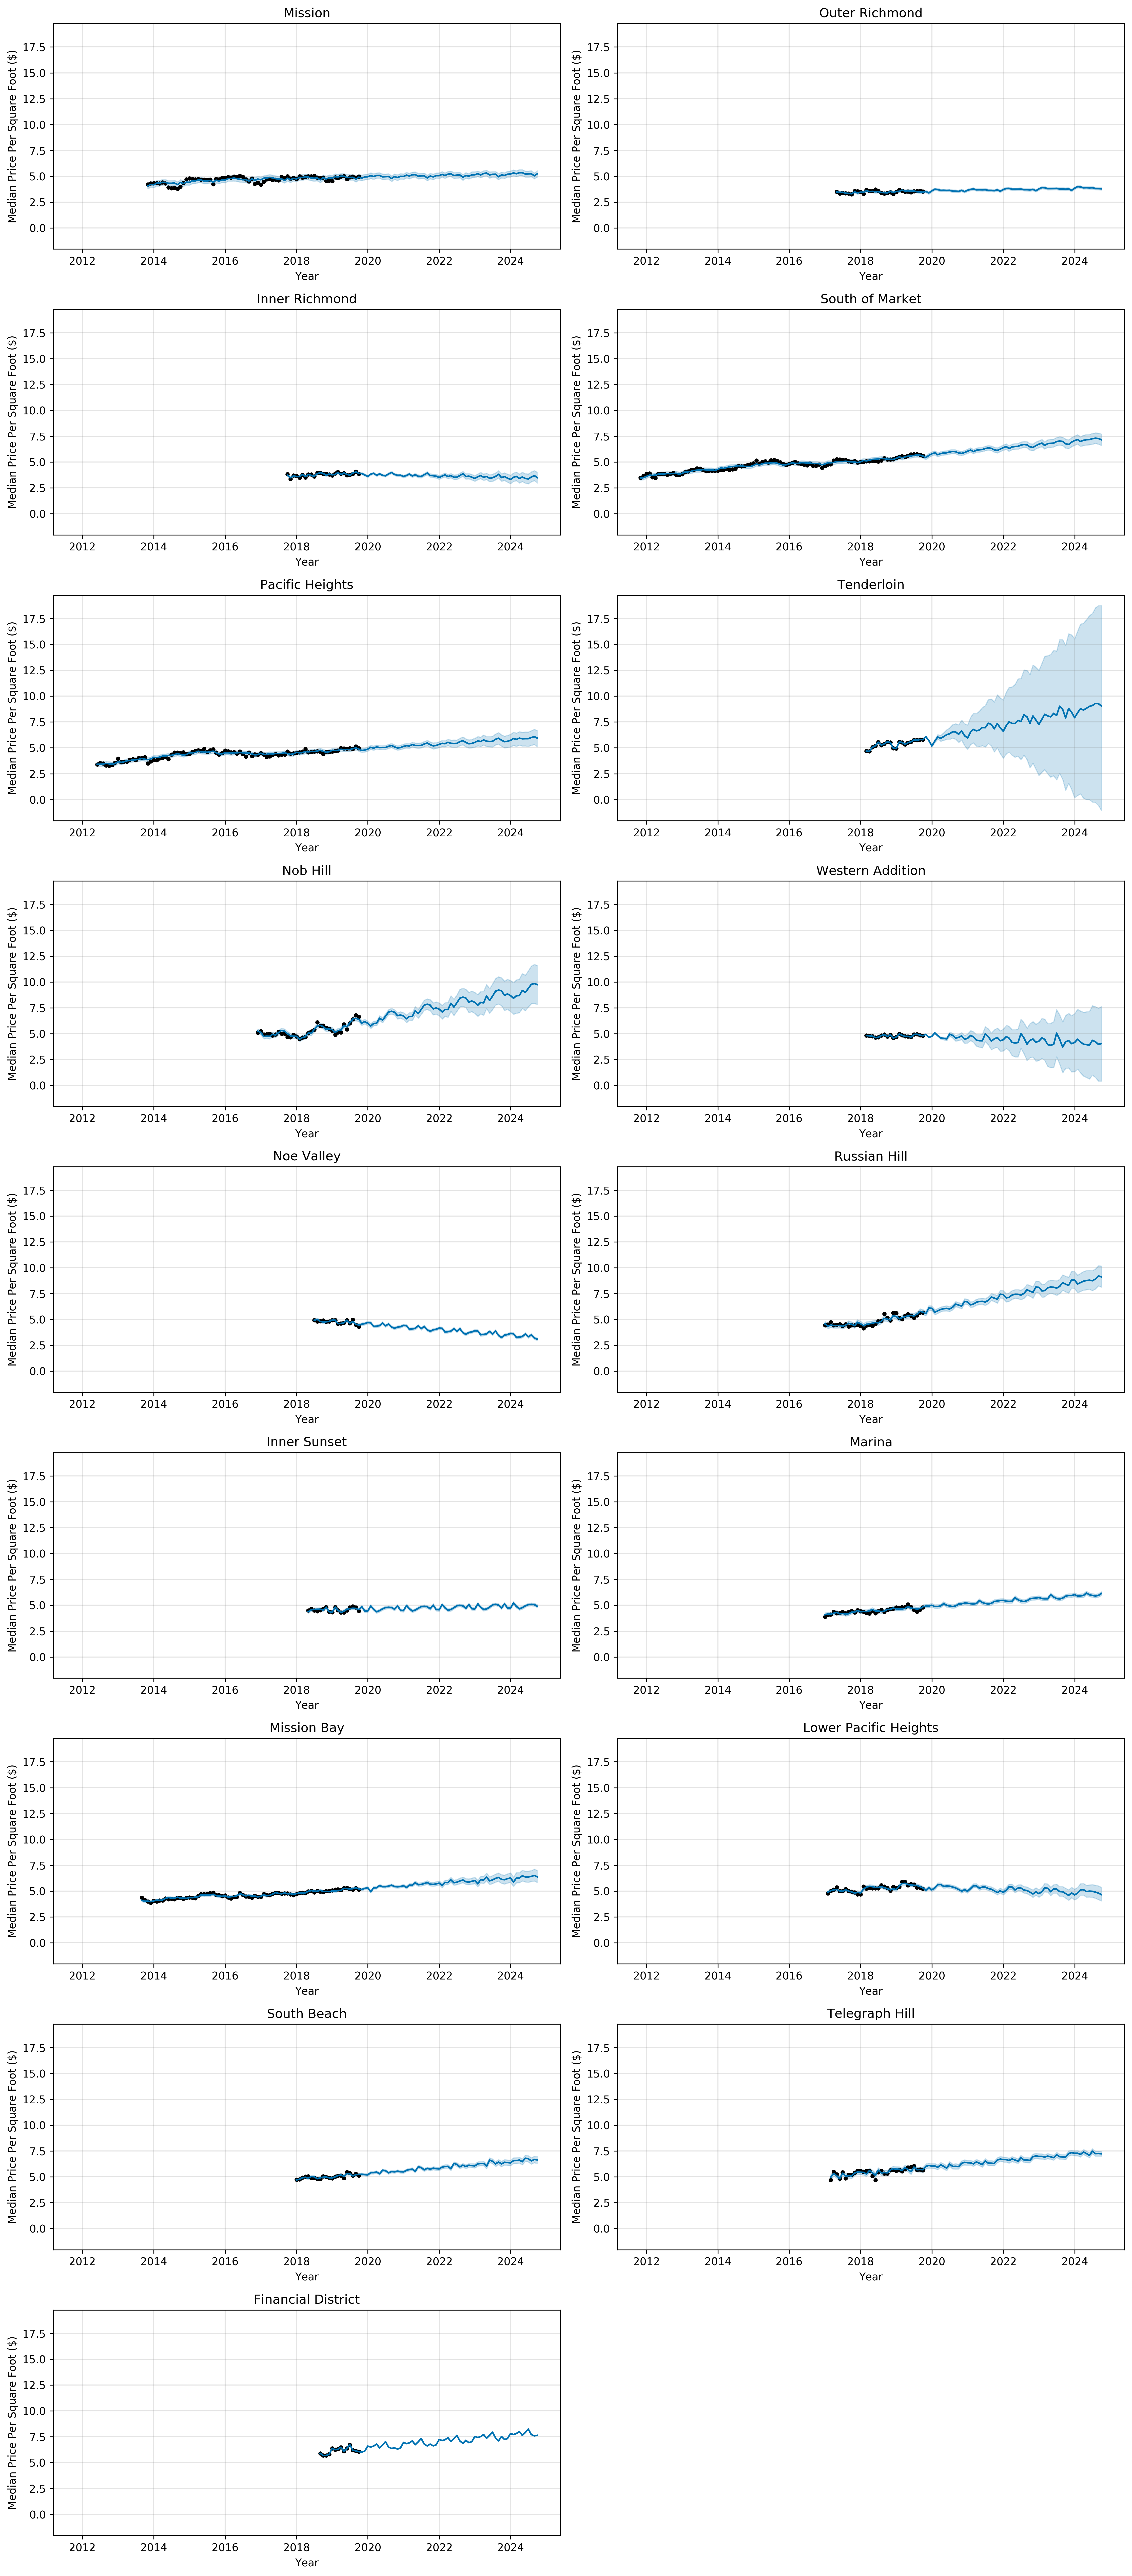

In [11]:
fig = plt.figure(facecolor='w', figsize=(15,len(preds)*2), dpi=300)
ax = None
pos = 1
for (city, (p,m)) in preds.items():
    if ax is not None:
        ax = fig.add_subplot((len(preds)/2 + 1), 2, pos, xlabel="Year", ylabel="Median Price Per Square Foot", sharex = ax, sharey = ax, title = city)
        #ax = fig.add_subplot(ax)
    else:
        ax = fig.add_subplot((len(preds)/2 + 1), 2, pos, title = city)
        #ax = fig.add_subplot(1,1, 1, xlabel="Year", ylabel="Median Home Price", )
    pos += 1
    fig = m.plot(p, xlabel = "Year", ylabel = "Median Price Per Square Foot ($)", ax=ax)

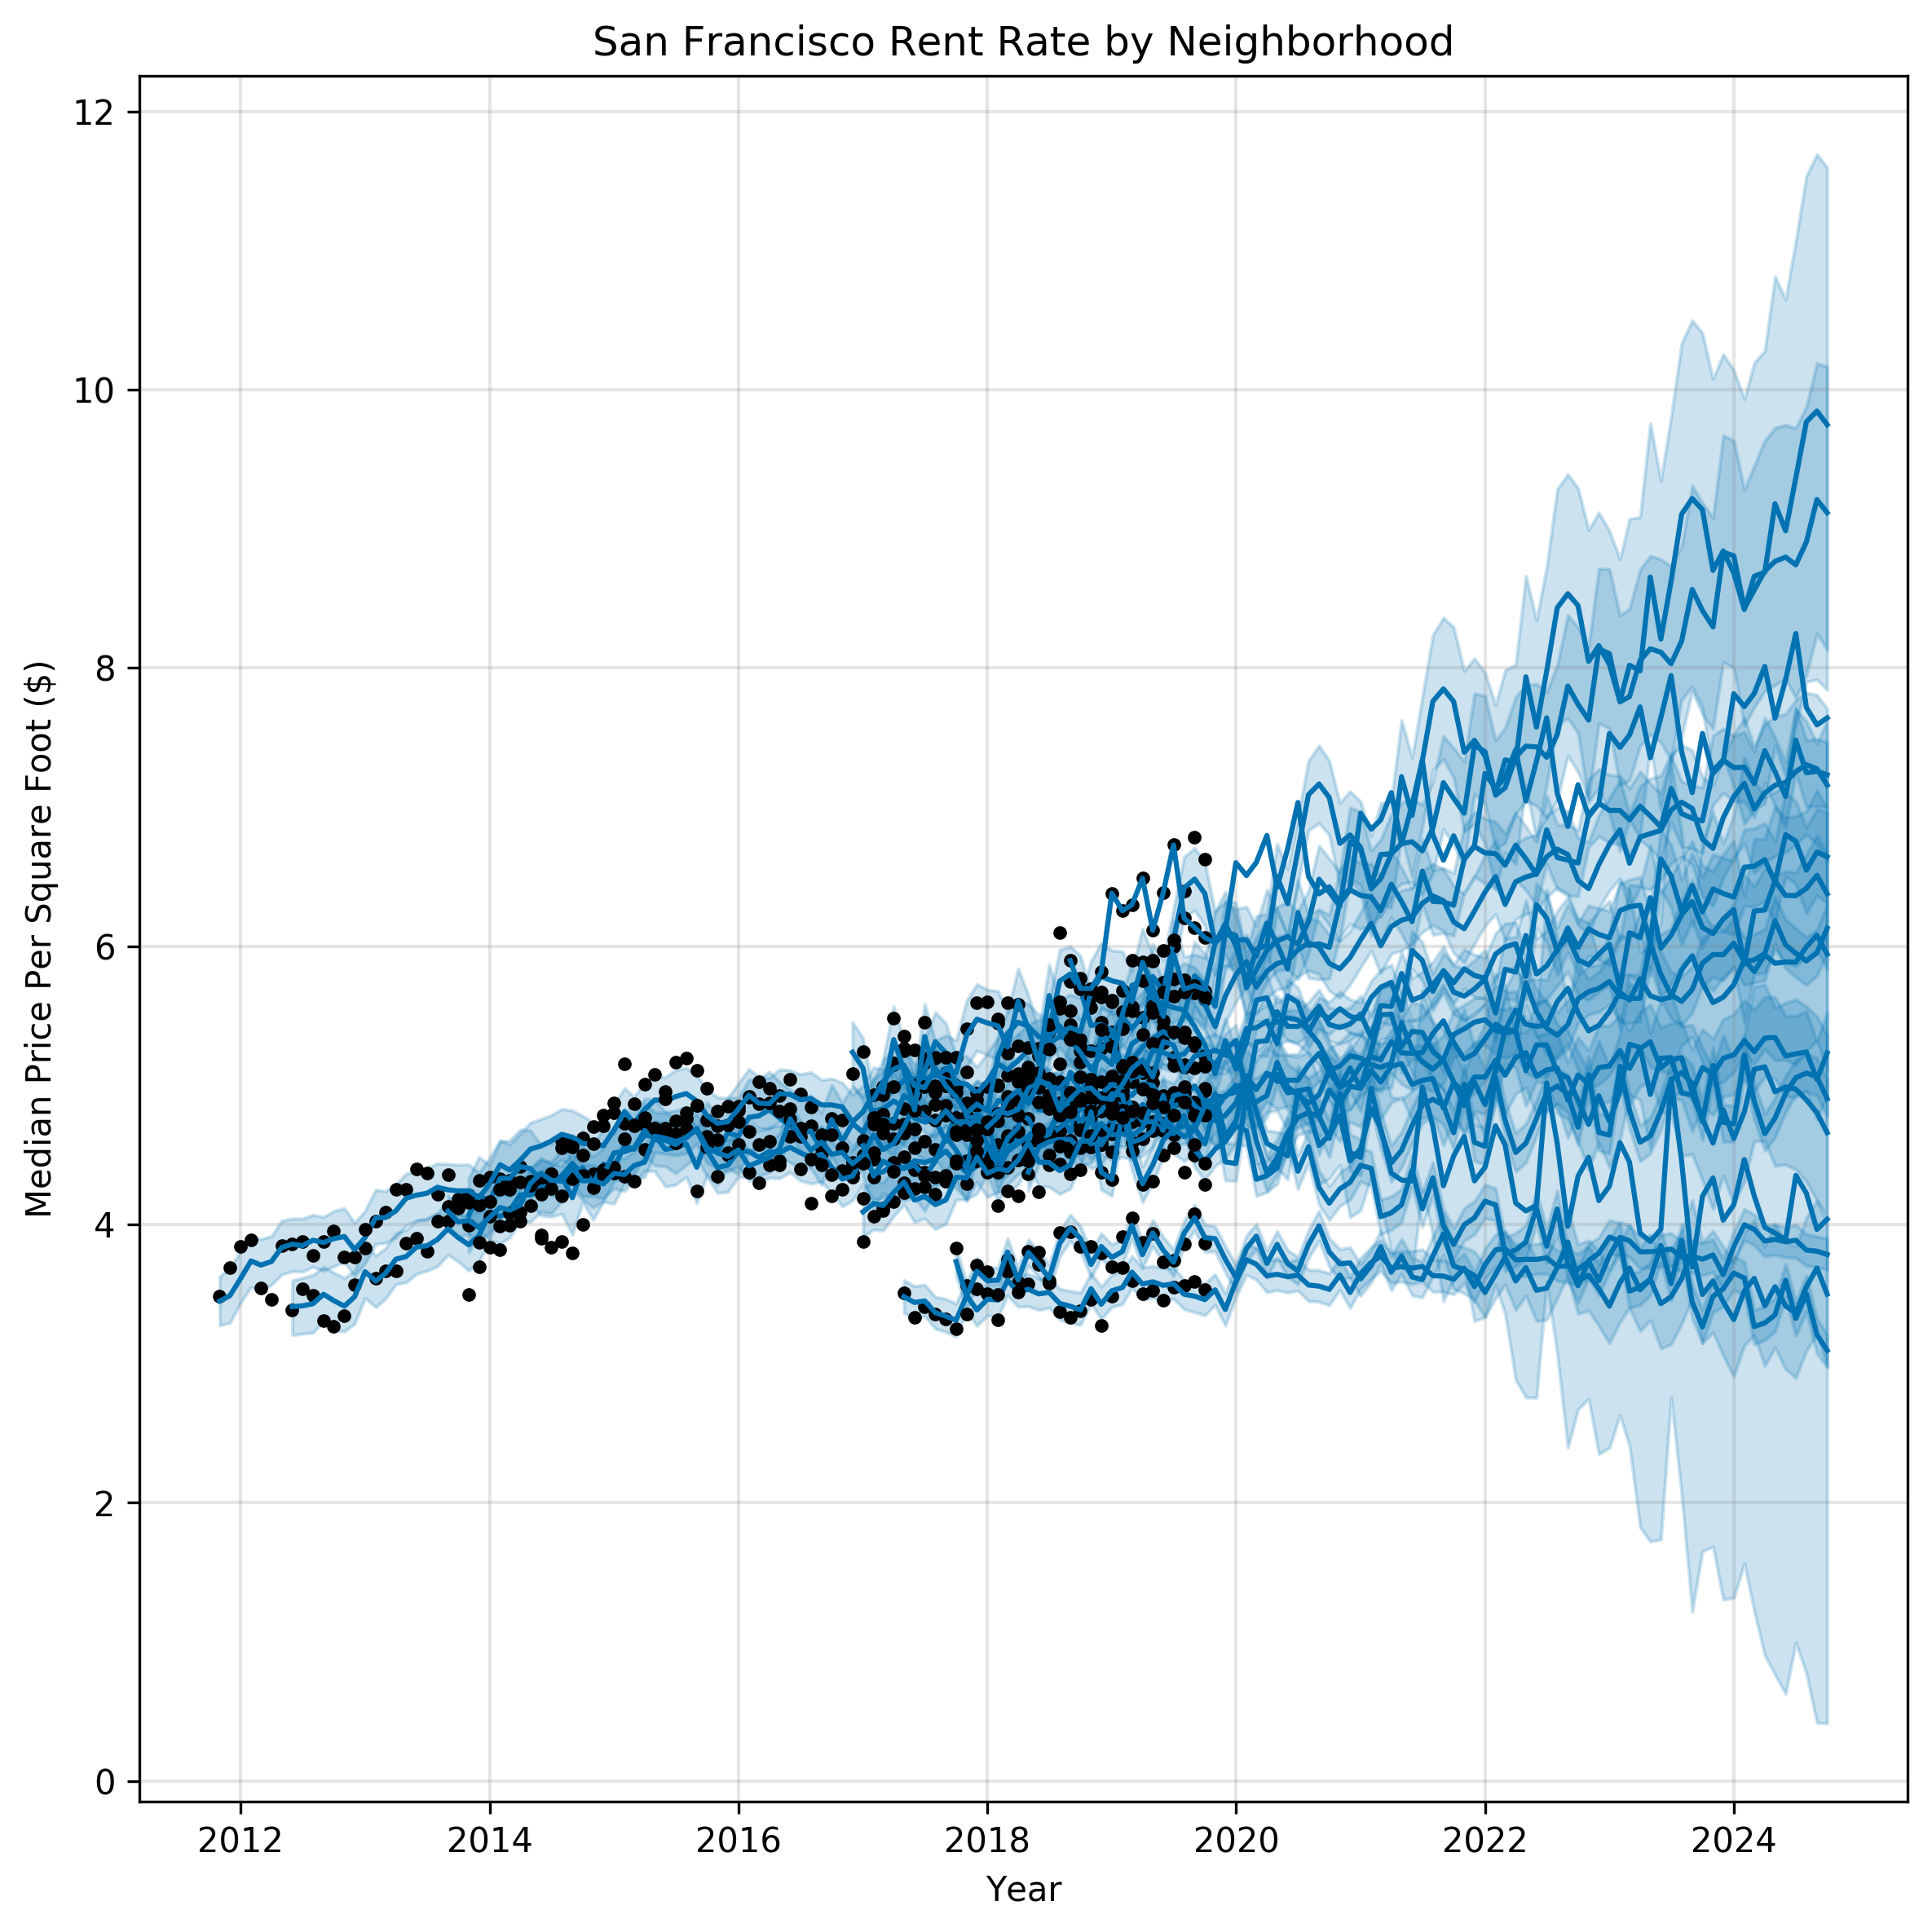

In [17]:
fig2 = plt.figure(facecolor='w', figsize=(8,8), dpi=300)
ax2 = None
for (city, (p,m)) in preds.items():
    if city == "Tenderloin":
        continue
    if ax2 is not None:
        ax2 = fig2.add_subplot(ax2)
    else:
        ax2 = fig2.add_subplot(1,1, 1, title="San Francisco Rent Rate by Neighborhood")
    pos += 1
    fig2 = m.plot(p, xlabel = "Year", ylabel = "Median Price Per Square Foot ($)", ax=ax2)

In [18]:
fig.savefig("/Users/potter/Pictures/ind_neighborhood_forecasts.png", transparent=True, dpi=300, format="png")
fig2.savefig("/Users/potter/Pictures/all_neighborhood_forecasts_outlier_removed.png", transparent=True, dpi=300, format="png")


Nob Hill
Russian Hill
Telegraph Hill
Financial District


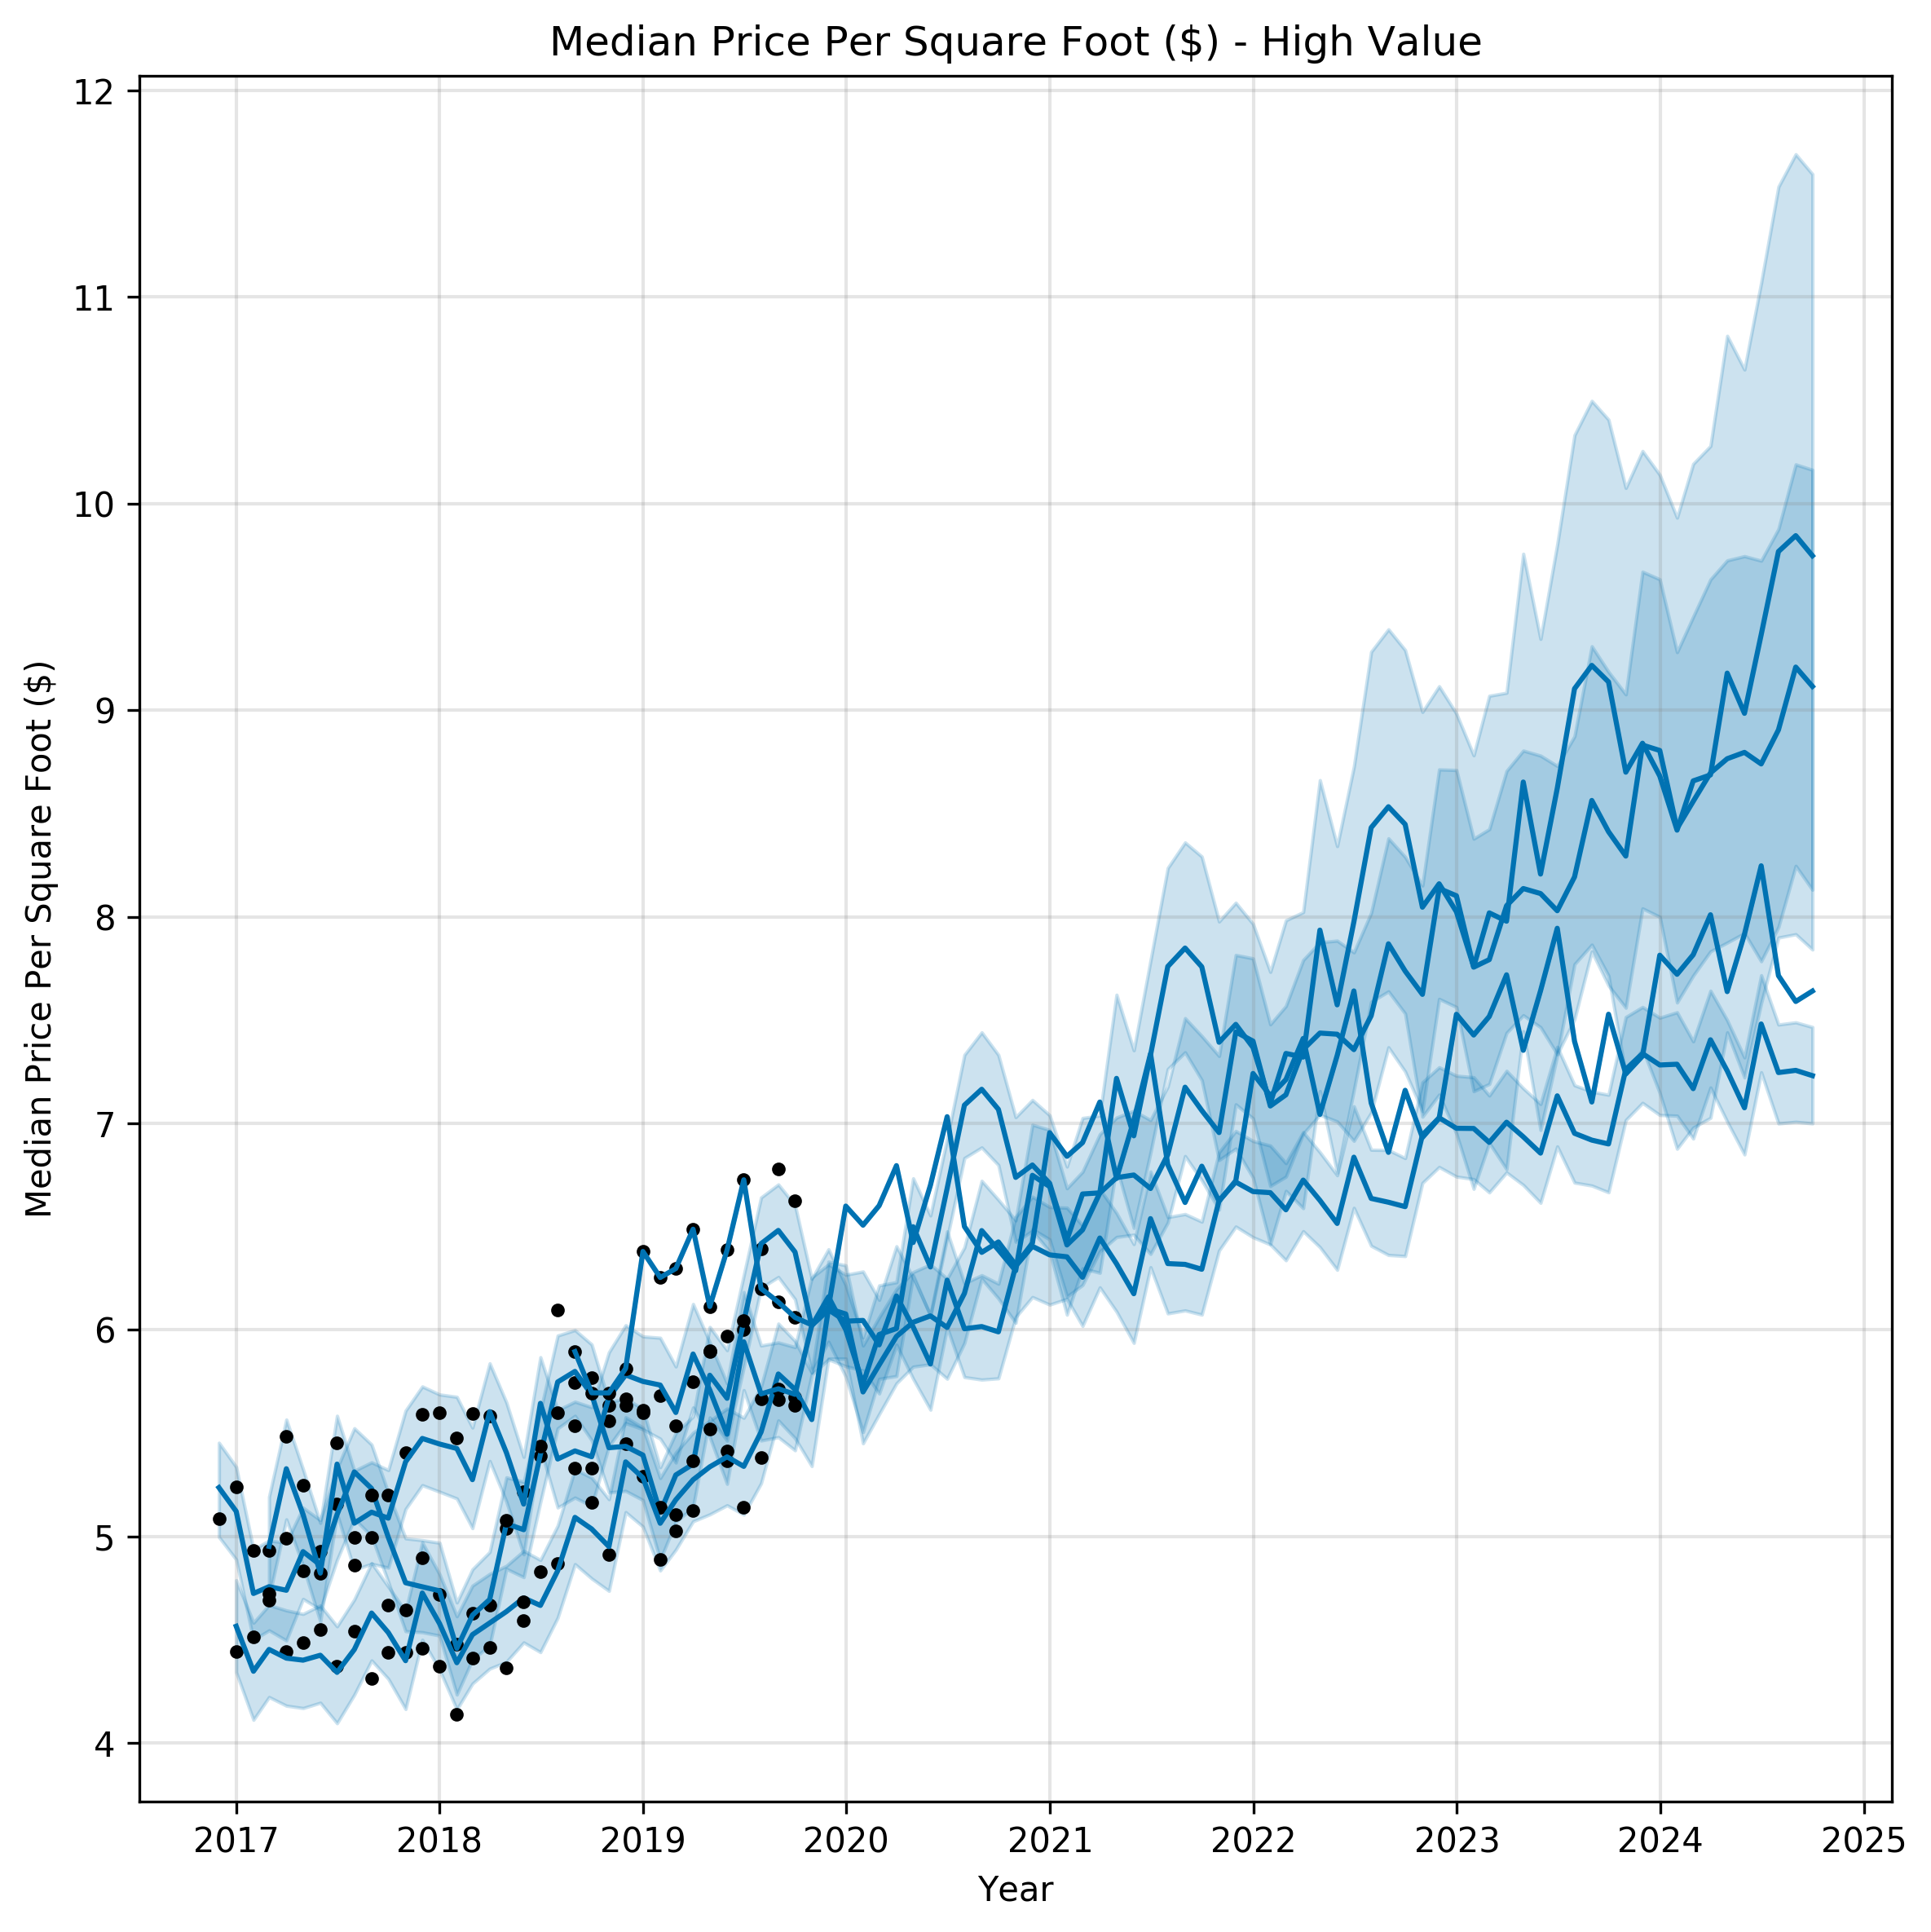

In [62]:
fig3 = plt.figure(facecolor='w', figsize=(8,8), dpi=300)
ax3 = None
for (city, (p,m)) in preds.items():
    if p[p.ds == "2024-09-30"].iloc[0].at['yhat'] - p[p.ds == "2019-09-01"].iloc[0].at['yhat'] > 1.5:
        if city == "Tenderloin":
            continue
        elif ax3 is not None:
            ax3 = fig3.add_subplot(ax3)
        else:
            ax3 = fig3.add_subplot(1,1, 1, title="Median Price Per Square Foot ($) - High Value")
        pos += 1
        fig3 = m.plot(p, xlabel = "Year", ylabel = "Median Price Per Square Foot ($)", ax=ax3)
        print(city)

In [63]:
fig3.savefig("/Users/potter/Pictures/high_neighborhood_forecasts.png", transparent=True, dpi=300, format="png")


In [65]:
data = []
for (city, (p,m)) in preds.items():
    v_19 = p[p.ds == "2019-09-01"].iloc[0].at['yhat']
    v_25 = p[p.ds == "2024-09-30"].iloc[0].at['yhat']
    delta_p =  v_25 - v_19 
    data.append({"neighborhood":city, "2019_val": v_19, "2025_val": v_25,
                 "delta": delta_p, "percent_change": delta_p/v_19})
    
pd.DataFrame(data)

neighborhood  2019_val  2025_val     delta  percent_change
0                 Mission  4.716224  5.232122  0.515898        0.109388
1          Outer Richmond  3.483845  3.783275  0.299430        0.085948
2          Inner Richmond  4.047703  3.498264 -0.549439       -0.135741
3         South of Market  5.659413  7.157028  1.497615        0.264624
4         Pacific Heights  4.994989  5.941853  0.946864        0.189563
5              Tenderloin  5.801762  9.048442  3.246680        0.559602
6                Nob Hill  6.481813  9.747710  3.265897        0.503856
7        Western Addition  4.855727  4.036687 -0.819040       -0.168675
8              Noe Valley  4.537192  3.094335 -1.442858       -0.318007
9            Russian Hill  5.786921  9.115223  3.328303        0.575142
10           Inner Sunset  4.693846  4.902719  0.208873        0.044499
11                 Marina  4.679449  6.128475  1.449026        0.309657
12            Mission Bay  5.318164  6.376326  1.058161        0.198971
13  Lower Pacific Heights  5.422031  4.658809 -0.763223       -0.140763
14            South Beach  5.208843  6.641553  1.432710        0.275053
15         Telegraph Hill  5.715302  7.230957  1.515655        0.265193
16     Financial District  6.134864  7.640575  1.505711        0.245435